# Sentinel-2 processing with eodag and snap : burnt areas mapping with gpt
__________

At the end of may, a wildfire began in the North of New Mexico, next to Cimarron, in Ute Park area. The Fire has burned 36,000 acres (14,569 hectares) of drought-parched grassland and timber since the wildfire broke out on Thursday.


(source: [Express](https://www.express.co.uk/news/world/969726/ute-park-fire-new-mexico-where-wildfire-spread-ute-park-map-NFSA))


In this tutorial we use eodag to recover a stack of data on the same tile and processing it with snap to get a burned area mask. We will able to display it on a dynamic map to evaluate the extent of damages.

To be able to follow this tutorial, you will need to install [Sen2Cor](http://step.esa.int/main/third-party-plugins-2/sen2cor/). The installation instructions are located [here](http://step.esa.int/thirdparties/sen2cor/2.5.5/docs/S2-PDGS-MPC-L2A-SRN-V2.5.5.pdf). Be sure to add the binary `L2A_Process` that comes with this tool suit in your system PATH.

In [1]:
import os

from eodag.api.core import EODataAccessGateway
from eodag.utils.logging import setup_logging


setup_logging(verbose=1)

workspace = 'eodag_workspace'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

dag = EODataAccessGateway()
product_type = 'S2_MSI_L1C'
extent = {
    'lonmin': -105.095901,
    'lonmax': -104.977112,
    'latmin': 36.500253,
    'latmax': 36.559015
}

2019-04-15 16:48:05,897-15s eodag.config                     [INFO    ] Loading user configuration from: /tmp/eodag_workspace/eodag_conf.yml


We want to frame the fire period by studying two images before and after, at the end of May and at the beginning of June. `sort_by_extent` returns the different searches sorted by extents, so we can easily work on the tile that cover the most the burned area, to perform temporal differences.

In [2]:
sorted_products = dag.sort_by_extent([
    dag.search(
        productType=product_type,
        start='2018-05-16', 
        end='2018-05-25',
        box=extent
    )[0],
    dag.search(
        productType=product_type,
        start='2018-06-05',
        end='2018-06-15',
        box=extent
    )[0]
])

2019-03-18 17:50:31,910-15s eodag.core                       [INFO    ] Searching product type 'S2_MSI_L1C' on provider: peps
2019-03-18 17:50:31,913-15s eodag.plugins.search.qssearch    [INFO    ] Sending count request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?box=-105.095901,36.500253,-104.977112,36.559015&startDate=2018-05-16&productType=S2MSI1C&completionDate=2018-05-25&maxRecords=1&page=1
2019-03-18 17:50:32,370-15s eodag.plugins.search.qssearch    [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?box=-105.095901,36.500253,-104.977112,36.559015&startDate=2018-05-16&productType=S2MSI1C&completionDate=2018-05-25&maxRecords=20&page=1
2019-03-18 17:50:32,892-15s eodag.core                       [INFO    ] Found 4 result(s) on provider 'peps'
2019-03-18 17:50:32,894-15s eodag.core                       [INFO    ] Searching product type 'S2_MSI_L1C' on provider: peps
2019-03-18 17:50:32,896-15s eodag.plugins.search.qssearch

We can check that the studied area is well covered by the tile **T13SDA**:


In [3]:
import folium

emap = folium.Map([36, -108.6], zoom_start=5)
layer = folium.features.GeoJson(
    data=sorted_products[1].as_geojson_object(),
    style_function=lambda x: {'fillColor': 'yellow'}
).add_to(emap)
emap

/home/aoyono/workspace/virtualenvs/eodag27/local/lib/python2.7/site-packages/folium/__init__.py:59: UserWarning: This version of folium is the last to support Python 2. Transition to Python 3 to be able to receive updates and fixes. Check out https://python3statement.org/ for more info.
  UserWarning


We take the two lasts products of this area, corresponding to May, 24th and June, 08th.

In [4]:
from eodag.utils import NotebookProgressCallback

paths = [
    product.download(progress_callback=NotebookProgressCallback()) 
    for product in sorted_products[1][-2:]
]

2019-03-18 17:50:51,853-15s eodag.plugins.download.http      [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S2ST/55b64437-f898-53d3-bf10-e5ce73bf1d0f/download
2019-03-18 17:50:52,266-15s eodag.plugins.download.http      [WARNING ] Downloaded product is not a Zip File. Please check its file type before using it
2019-03-18 17:50:52,270-15s eodag.api.product                [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/55b64437-f898-53d3-bf10-e5ce73bf1d0f/download
2019-03-18 17:50:52,276-15s eodag.plugins.download.http      [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S2ST/617aceed-0bb5-5f79-9ba2-c2e3cfbeca49/download
2019-03-18 17:50:52,769-15s eodag.plugins.download.http      [WARNING ] Downloaded product is not a Zip File. Please check its file type before using it
2019-03-18 17:50:52,774-15s eodag.api.product                [INFO    ] Remote location of

In [ ]:
import subprocess

for prod in paths:
    prod = prod[7:] if prod.startswith('file://') else prod
    subprocess.call([
        'L2A_Process',
        prod
])

In [5]:
    
# We build the path to the new L2A process product
for i, p in enumerate(paths):
    splitted_path = p.split('/')
    splitted_path[-1] = splitted_path[-1].replace('L1C', 'L2A')
    paths[i] = '/'.join(splitted_path)
    paths[i] = paths[i][7:] if paths[i].startswith('file://') else paths[i]

We write the first graph to pre-process the products. The idea is to isolate the bands of interest and resample it; then create a cloud mask and a first bandmath, the Normalized Burn Ratio (NBR). With the merge, we keep all the output bands into the same product. Finally, we apply it to the two images to compare the NBR result.

In [9]:
graph_preprocess = os.path.join(workspace, 'BurnedAreas_NBR.xml')
with open(graph_preprocess, 'w') as g_1:
    g_1.write(
"""
<graph id="Graph">
  <version>1.0</version>
    <node id="Read">
      <operator>Read</operator>
      <sources/>
      <parameters>
        <file>${inputproduct}</file>
      </parameters>
    </node>
    <node id="Resample">
      <operator>Resample</operator>
        <sources>
          <sourceProduct refid="Read"/>
        </sources>
      <parameters>
        <referenceBand>B2</referenceBand>
      </parameters>
    </node>
    <node id="BandMaths">
      <operator>BandMaths</operator>
      <sources>
        <sourceProduct refid="Resample"/>
      </sources>
      <parameters>
        <targetBands>
          <targetBand>
            <name>CloudMask</name>
            <type>float32</type>
            <expression>
                if (scl_cloud_medium_proba || scl_cloud_high_proba || scl_thin_cirrus)
                then 
                    1
                else 
                    0
            </expression>
          </targetBand>
          <targetBand>
            <name>NBR</name>
            <type>float32</type>
            <expression>
                (B8-B12)/(B8+B12)
            </expression>
          </targetBand>
        </targetBands>
      </parameters>
    </node>
    <node id="Merge">
      <operator>Merge</operator>
      <sources>
        <masterProduct>Resample</masterProduct>
        <sourceProducts>BandMaths</sourceProducts>
      </sources>
    </node>
    <node id="SubSet">
      <operator>Subset</operator>
      <sources>
        <sourceProduct refid="Merge"/>
      </sources>
      <parameters>
        <sourceBands>B3,B8,B12,CloudMask,NBR</sourceBands>
        <region>6000,3000,5980,5980</region>
      </parameters>
    </node>
    <node id="Write1">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="SubSet"/>
      </sources>
      <parameters>
        <file>${outputproduct}</file>
      </parameters>
    </node>
    <node id="Write2">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="SubSet"/>
      </sources>
      <parameters>
        <file>${visu}</file>
        <formatName>Geotiff</formatName>
      </parameters>
    </node>
</graph>
"""
)

In [7]:
# Before calling gpt, we must set the environment
# variable LD_LIBRARY_PATH to the current directory
os.environ['LD_LIBRARY_PATH'] = '.'

subprocess.call([
    'gpt', 
    graph_preprocess, 
    '-Pinputproduct={}'.format(paths[0]),
    '-Poutputproduct={}'.format(os.path.join(workspace, 'preprocessed_before')),
    '-Pvisu={}'.format(os.path.join(workspace, 'preprocessed_before'))
])
subprocess.call([
    'gpt', 
    graph_preprocess, 
    '-Pinputproduct=%s' % paths[1], 
    '-Poutputproduct={}'.format(os.path.join(workspace, 'preprocessed_after')),
    '-Pvisu={}'.format(os.path.join(workspace, 'preprocessed_after'))
])

We can have a look on the NBR band and compare the two dates:

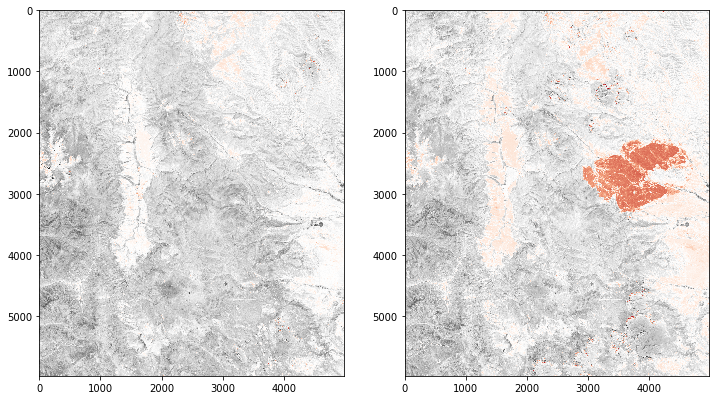

In [8]:
import matplotlib.pyplot as plt
from osgeo import gdal

burned_areas_before = gdal.Open(
    os.path.join(workspace, 'preprocessed_before.tif')
).ReadAsArray()
burned_areas_after = gdal.Open(
    os.path.join(workspace, 'preprocessed_after.tif')
).ReadAsArray()
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(burned_areas_before[4,:,:], cmap='RdGy')
plt.subplot(122)
plt.imshow(burned_areas_after[4,:,:], cmap='RdGy')

Water bodies can show similar NBR difference, like we see it above with a river snaking in the south of the burned area. Therefore, it is necessary to mask them out.
We  also need to mask out clouds occurring in either input image. For this purpose, we will create a single combined water and cloud mask.

To detect  the  water bodies we will use the Normalized Difference Water Index (NDWI ).


In [9]:
graph_cloudwatermask = os.path.join(workspace, 'BurnedAreas_CloudWaterMask.xml')
with open(graph_cloudwatermask, 'w') as g_2:
    g_2.write(
"""
<graph id="Graph">
  <version>1.0</version>
    <node id="Collocate">
      <operator>Collocate</operator>
      <sources>
        <master>${master}</master>
        <slave>${slave}</slave>
      </sources>
      <parameters>
        <masterComponentPattern>${ORIGINAL_NAME}_May</masterComponentPattern>
        <slaveComponentPattern>${ORIGINAL_NAME}_June</slaveComponentPattern>
      </parameters>
    </node>
    <node id="BandMaths">
      <operator>BandMaths</operator>
      <sources>
        <sourceProduct refid="Collocate"/>
      </sources>
      <parameters>
        <targetBands>
          <targetBand>
            <name>cloud_water_mask</name>
            <type>float32</type>
            <expression>
                if (CloudMask_May > 0 
                    or CloudMask_June > 0
                    or ((B3_May-B8_May)/(B3_May+B8_May)) >= 0.0)
                then 
                    1
                else
                    0
            </expression>
          </targetBand>
        </targetBands>
      </parameters>
    </node>
    <node id="Merge">
      <operator>Merge</operator>
      <sources>
        <masterProduct>Collocate</masterProduct>
        <sourceProducts>BandMaths</sourceProducts>
      </sources>
    </node>
    <node id="Write">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="Merge"/>
      </sources>
      <parameters>
        <file>${outputproduct}</file>
      </parameters>
    </node>
</graph>

"""
)

In [10]:
subprocess.Popen([
    'gpt', 
    graph_cloudwatermask,
    '-Smaster={}'.format(os.path.join(workspace, 'preprocessed_before.dim')),
    '-Sslave={}'.format(os.path.join(workspace, 'preprocessed_after.dim')),
    '-Poutputproduct={}'.format(os.path.join(workspace, 'cloudwater_mask'))
])

Finally, we apply the last bandmath, the Relativized Band Ratio (RBR) that takes the two products in input, to perform difference between the first and the second date and maximize the burned area delimitation. To discriminate real burned areas of others lands, we set a low-value limit at 0.27, corresponding to the minimum where we can affirm that it is a burned area.

In [11]:
graph_RBR = os.path.join(workspace, 'BurnedAreas_RBR.xml')
with open(graph_RBR, 'w') as g_3:
    g_3.write(
"""
<graph id="Graph">
  <version>1.0</version>
    <node id="Read">
      <operator>Read</operator>
      <sources/>
      <parameters>
        <file>${inputproduct}</file>
      </parameters>
    </node>
    <node id="BandMaths1">
      <operator>BandMaths</operator>
      <sources>
        <sourceProduct refid="Read"/>
      </sources>
      <parameters>
        <targetBands>
          <targetBand>
            <name>RBR</name>
            <type>float32</type>
            <expression>
                if cloud_water_mask == 0
                then
                    ((NBR_May - NBR_June) / (NBR_May + 1.001))
                else
                    NaN
            </expression>
          </targetBand>
        </targetBands>
      </parameters>
    </node>
    <node id="BandMaths2">
      <operator>BandMaths</operator>
      <sources>
        <sourceProduct refid="BandMaths1"/>
      </sources>
      <parameters>
        <targetBands>
          <targetBand>
            <name>RBR</name>
            <type>float32</type>
            <expression>
                if RBR > 0.27 then RBR else NaN
            </expression>
          </targetBand>
        </targetBands>
      </parameters>
    </node>
    <node id="Write">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="BandMaths2"/>
      </sources>
      <parameters>
        <file>${outputproduct}</file>
        <formatName>Geotiff</formatName>
      </parameters>
    </node>  
</graph>
"""
)

In [12]:
subprocess.Popen([
    'gpt', 
    graph_RBR,
    '-Pinputproduct={}'.format(os.path.join(workspace, 'cloudwater_mask.dim')),
    '-Poutputproduct={}'.format(os.path.join(workspace, 'RBR_product'))
])

We have a final mask that only covers areas actually burned . It can be export as a KMZ to be viewed in Google Earth or any cartographic service. To visualize it on a map, we reduce image resolution and reproject it in mercator projection.

In [13]:
graph_visu = os.path.join(workspace, 'vizualisation.xml')
with open(graph_visu, 'w') as g_4:
    g_4.write(
"""
<graph id="Graph">
  <version>1.0</version>
    <node id="Read">
      <operator>Read</operator>
      <sources/>
      <parameters>
        <file>${inputproduct}</file>
      </parameters>
    </node>
    <node id="Resample">
      <operator>Resample</operator>
      <sources>
        <sourceProduct refid="Read"/>
      </sources>
      <parameters>
        <targetWidth>2232</targetWidth>
        <targetHeight>2472</targetHeight>
      </parameters>
    </node>
    <node id="Write">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="Resample"/>
      </sources>
      <parameters>
        <file>${outputproduct}</file>
        <formatName>Geotiff</formatName>
      </parameters>
    </node>
</graph>
"""
)

subprocess.Popen([
    'gpt', 
    graph_visu,
    '-Pinputproduct={}'.format(os.path.join(workspace, 'RBR_product.tif')),
    '-Poutputproduct={}'.format(os.path.join(workspace, 'RBR_product_visu'))
])

We make the reprojection:

In [14]:
def warpBasic(inputImage, warpedTiff, srs,):
        cmd = ["gdalwarp",
               "-t_srs", srs,
               "-multi",
               "-q",
               "-wo", "NUM_THREADS=ALL_CPUS",
               "-r", "bilinear",
               "-overwrite",
               "-dstnodata", "None",
               "-dstalpha"]
        cmd.extend([inputImage, warpedTiff])
        subprocess.call(cmd)
warpBasic(
    os.path.join(workspace, 'RBR_product_visu.tif'),
    os.path.join(workspace, 'RBR_product_visu_3857.tif'),
    'EPSG:3857'
)

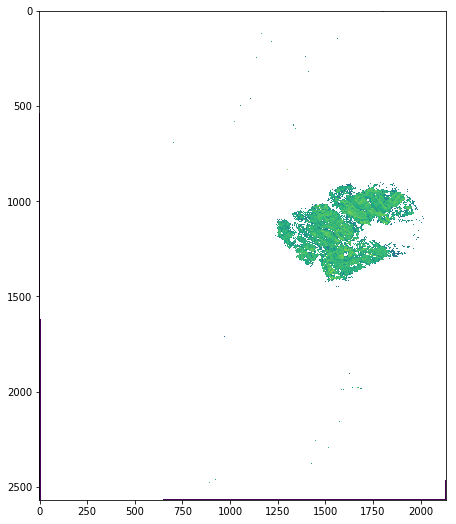

In [15]:
burned_areas = gdal.Open(
    os.path.join(workspace, 'RBR_product_visu_3857.tif')
).ReadAsArray()[0]
plt.figure(figsize=(9, 9))
im = plt.imshow(burned_areas)

Now we display the mask on a map base like Open Street map:

In [16]:
from folium.raster_layers import ImageOverlay
import imageio
import numpy as np


final_mask = np.zeros((burned_areas.shape[0], burned_areas.shape[1], 4))
final_mask[:,:,3] = burned_areas
imageio.imwrite(os.path.join(workspace, 'burned_areas_gpt.png'), final_mask)

m = folium.Map([36.5, -105], zoom_start=9, tiles='openstreetmap')
ImageOverlay(
    image=os.path.join(workspace, 'burned_areas_gpt.png'),
    name='Mercator projection SW',
    bounds=[[36.2361722222, -105.448691667], [36.7767944444, -104.8907]],
    opacity=1,
).add_to(m)

folium.LayerControl().add_to(m)
m